In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

from train import train_MSAP
from dist_matrix import gen_dist_matrix

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

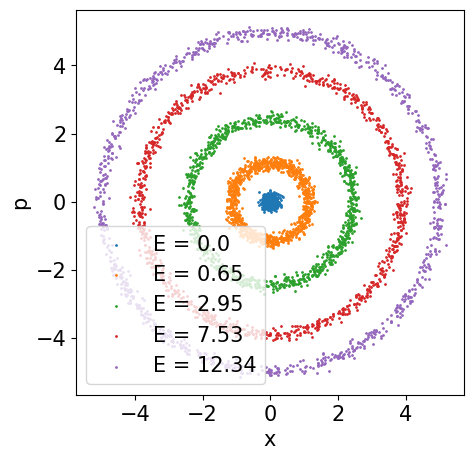

In [2]:
ho = np.load("data/harmonic_oscillator.npz")

data = ho["data"]
E = ho["E"].T[0]

plt.figure(figsize=(5, 5))
idx = np.argsort(E)[(np.arange(5) * (len(E) - 1) / 4).astype(int)]
for i in idx:
    plt.scatter(*data[i].T, label=f"E = {round(E[i], 2)}", s=1)

plt.legend()

plt.xlabel("x")
plt.ylabel("p")

plt.savefig("graphs/ho_traj.pdf")

plt.show()

In [3]:
# data = StandardScaler().fit_transform(data.reshape(data.shape[0] * data.shape[1], -1)).reshape(data.shape)
# dmat = gen_dist_matrix(data, name="data/ho")
dmat = np.load("data/ho_dmat.npz")["dmat"]

valid_size = len(dmat) // 5
train_size = len(dmat) - valid_size

train_idx, valid_idx = train_test_split(torch.arange(len(dmat)), test_size=valid_size)

dmat = torch.tensor(dmat, dtype=torch.float32)
train_dmat = dmat[train_idx[:, None], train_idx[None, :]]
valid_dmat = dmat[valid_idx[:, None], train_idx[None, :]]

In [ ]:
cfg = {
    "target_dim": 5,
    "intermediate_dim": 8,
    "intermediate_layers": 2,
}

models_ho, losses_ho = train_MSAP(train_dmat, valid_dmat, cfg, "ho_v1", min_delta=0.1, patience=50, project_name="MSAP", N_inits=2)

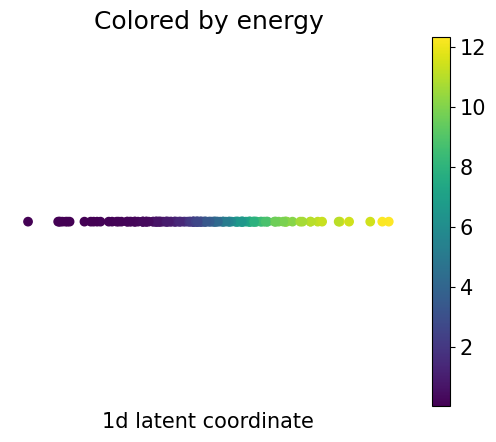

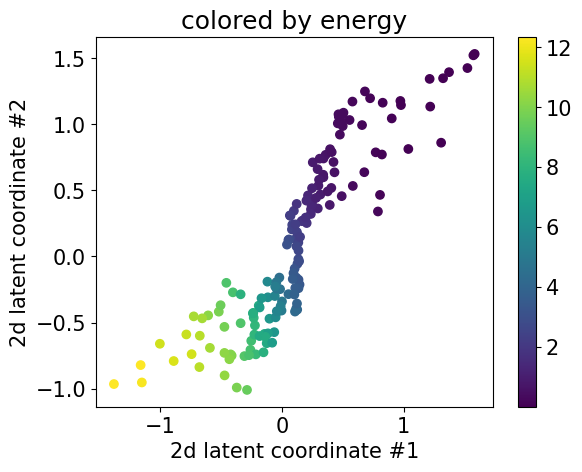

In [8]:
model1d = models_ho[0]

plt.figure()
plt.scatter(model1d.latent.cpu().detach().T[0], [np.zeros_like(train_idx)], c=E[train_idx])
plt.xlabel("1d latent coordinate")
plt.gca().yaxis.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.title("Colored by energy")
plt.colorbar()
plt.savefig("graphs/ho_latent1d.pdf")

model2d = models_ho[1]

plt.figure()
plt.scatter(*model2d.latent.cpu().detach().T, c=E[train_idx])
plt.xlabel(f"2d latent coordinate #1")
plt.ylabel(f"2d latent coordinate #2")
plt.title(f"colored by energy")
plt.colorbar()
plt.savefig("graphs/ho_latent2d.pdf")

plt.show()

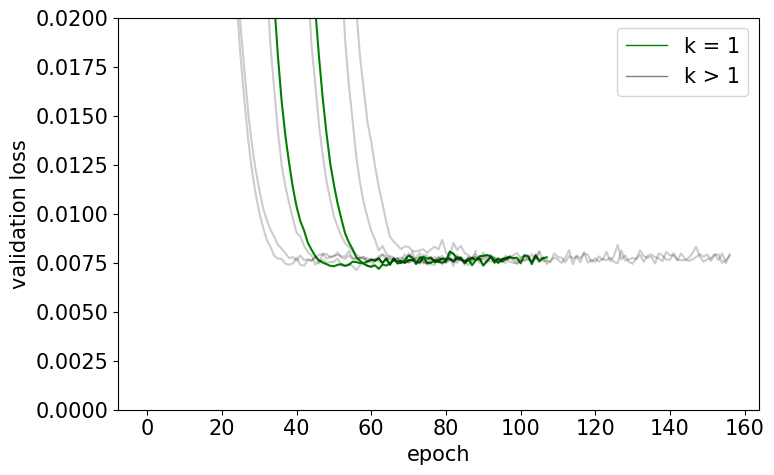

In [4]:
# to plot this graph you have to download the validation loss data from the wandb to the data folder


import pandas as pd
from matplotlib.lines import Line2D

learning_curves = pd.read_csv("data/ho_learning_curves.csv")

plt.figure(figsize=(8, 5))
epoch = learning_curves["epoch"]
for i in range(1, 5):
    c = "green" if i == 1 else "black"
    alpha = 1 if i == 1 else 0.2
    for init in range(1, 3):
        valid_loss = learning_curves[f"ho; latent_dim: {i}, init #{init} - valid_loss"]
        plt.plot(epoch, valid_loss, c=c, alpha=alpha)

custom_lines = [Line2D([0], [0], color="green", lw=1),
                Line2D([0], [0], color="gray", lw=1)]

plt.legend(custom_lines, ["k = 1", "k > 1"])

plt.ylim(0, 0.02)

plt.xlabel("epoch")
plt.ylabel("validation loss")

plt.tight_layout()

plt.savefig("graphs/ho_learning_curves.pdf", bbox_inches="tight")

plt.show()